In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pydot
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report


import statsmodels.api as sm
import math
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('seaborn-white')

C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [4]:
def show_grid_search(model, X_train, y_train, tuned_parameters, scores):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            model, tuned_parameters, cv=3,
            verbose=10, scoring='%s_macro' % score#, n_jobs=-1
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

In [5]:
# Load data
df = pd.read_csv("nhl_game_data/game_teams_stats.csv")
# normalize 
df['shots'] = (df['shots'] - df['shots'].mean()) / (df['shots'].max() - df['shots'].min())
df['goals'] = (df['goals'] - df['goals'].mean()) / (df['goals'].max() - df['goals'].min())
df['pim'] = (df['pim'] - df['pim'].mean()) / (df['pim'].max() - df['pim'].min())
df['powerPlayGoals'] = (df['powerPlayGoals'] - df['powerPlayGoals'].mean()) / (df['powerPlayGoals'].max() - df['powerPlayGoals'].min())
df['giveaways'] = (df['giveaways'] - df['giveaways'].mean()) / (df['giveaways'].max() - df['giveaways'].min())
df['takeaways'] = (df['takeaways'] - df['takeaways'].mean()) / (df['takeaways'].max() - df['takeaways'].min())
df['faceOffWinPercentage'] = (df['faceOffWinPercentage'] - df['faceOffWinPercentage'].mean()) / (df['faceOffWinPercentage'].max() - df['faceOffWinPercentage'].min())
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,0.025695,-0.081415,31,0.009968,3,0.067941,-0.087329,-0.073560,0.002587
1,2011030221,4,home,True,OT,Peter Laviolette,0.125695,0.103770,27,-0.022819,6,0.067941,0.087329,0.120885,-0.094187
2,2011030222,1,away,True,REG,Peter DeBoer,0.125695,0.085252,32,0.009968,4,-0.098726,0.015411,-0.018004,0.002587
3,2011030222,4,home,False,REG,Peter Laviolette,-0.174305,-0.192526,24,0.119258,5,-0.098726,-0.015411,0.009773,-0.029671
4,2011030223,4,away,False,OT,Peter Laviolette,0.025695,-0.044378,28,-0.033747,5,0.067941,0.013699,-0.184671,-0.190961


In [6]:
# Change catergorical data to numerical
df['won_true'] = df['won'].astype(int)
# Features
X = df[['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage']]
# Target Variable
y = df['won_true']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [8]:
dtc = DecisionTreeClassifier()

In [9]:
tuned_parameters = [{'criterion':('gini', 'entropy'),
                    'splitter':('best', 'random'),
                    'max_features':('auto', 'sqrt', 'log2'),
                    'max_leaf_nodes':(10, 25, 50, 100, 150),
                    'class_weight':['balanced']},
                   {'criterion':('gini', 'entropy'),
                    'splitter':('best', 'random')}]

scores = ['precision', 'recall']

show_grid_search(dtc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=best, score=0.773, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=best, score=0.748, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=best, score=0.703, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=10, splitter=random, score=0.612, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s



[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=50, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=50, splitter=random, score=0.574, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=best, score=0.699, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=best, score=0.772, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=best, score=0.759, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=100, splitter=random 
[

[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=25, splitter=random, score=0.729, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=25, splitter=random, score=0.733, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=25, splitter=random, score=0.771, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=50, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=50, splitter=best, score=0.772, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=50, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=50, splitter=best, scor

[CV]  class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=150, splitter=random, score=0.744, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=best, score=0.654, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=best, score=0.775, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=best, score=0.773, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=10, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, max_leaf_nodes=1

[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=best, score=0.620, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=best, score=0.618, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=best, score=0.773, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=random, score=0.754, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s



[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=25, splitter=random, score=0.615, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=25, splitter=random, score=0.683, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=25, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=25, splitter=random, score=0.643, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=50, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=50, splitter=best, score=0.737, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=auto, max_leaf_nodes=50, splitter=best 
[C

[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=best, score=0.558, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=best, score=0.748, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=best 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=best, score=0.772, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=random, score=0.609, total=   0.0s
[CV] class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=random 
[CV]  class_weight=balanced, criterion=gini, max_features=log2, max_leaf_nodes=10, splitter=random, score=

[CV]  class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=100, splitter=random, score=0.690, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=100, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=100, splitter=random, score=0.656, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=100, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=100, splitter=random, score=0.717, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=150, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=150, splitter=best, score=0.769, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, max_leaf_nodes=150, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, max

[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=best, score=0.731, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=best, score=0.698, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=best 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=best, score=0.756, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=random, score=0.604, total=   0.0s
[CV] class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=50, splitter=random 
[CV]  class_weight=balanced, criterion=entropy, max_features=log2, max_leaf_nodes=

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    2.2s finished


In [10]:
#{'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 100, 'splitter': 'best'}
dtc = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_features='auto', max_leaf_nodes=100, splitter='best')
dtc = dtc.fit(X_train,y_train)

In [14]:
#Predict the response for test dataset
pred = dtc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7168051304474566


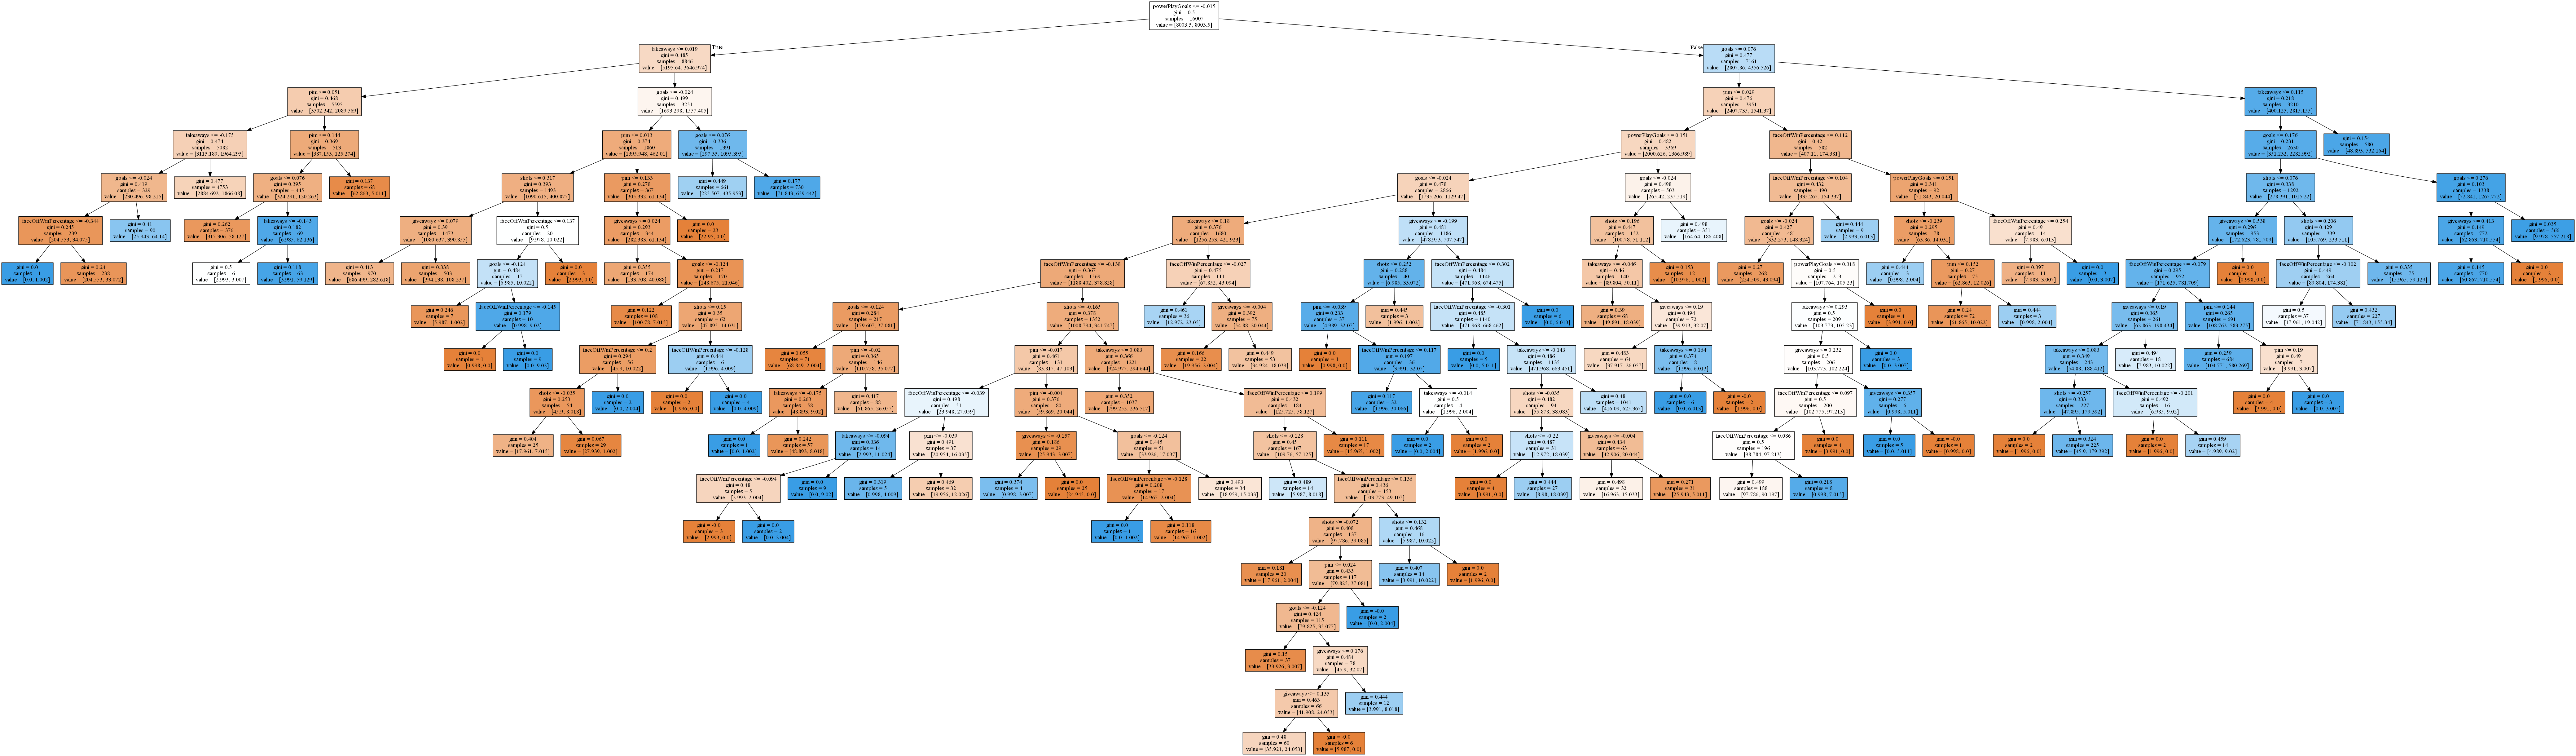

In [15]:
graph, = print_tree(dtc, features=['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage'])
Image(graph.create_png())